Here is the ADS we are working on

In [2]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors


EMBEDDING_FILES = [
    'input/crawl-300d-2M.gensim',
    'input/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
    

train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

#sample_weights = np.ones(len(x_train), dtype=np.float32)
#sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
#sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
#sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
#sample_weights /= sample_weights.mean()

#embedding_matrix = np.concatenate(
#    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

#checkpoint_predictions = []
#weights = []



In [3]:
import tensorflow as tf
model = tf.keras.models.load_model("D:\Project\RDS\RDS-Final-Project\my_model.h5")

In [9]:
model.predict(x_test, batch_size=2048)

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node model_2/bidirectional_3/forward_cu_dnnlstm_3/CudnnRNNV2}} with these attrs: [direction="unidirectional", seed=0, seed2=0, dropout=0, T=DT_FLOAT, rnn_mode="lstm", input_mode="linear_input", is_training=true]
Registered devices: [CPU]
Registered kernels:
  <no registered kernels>

	 [[model_2/bidirectional_3/forward_cu_dnnlstm_3/CudnnRNNV2]] [Op:__inference_predict_function_2053]

In [5]:
import shap
explainer = shap.Explainer(model, x_train, output_names=y_train)

In [8]:
shap_values = explainer.shap_values(x_test)

ResourceExhaustedError: Exception encountered when calling layer 'embedding_2' (type Embedding).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[10712,220,600] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ResourceGather] name: 

Call arguments received by layer 'embedding_2' (type Embedding):
  • inputs=tf.Tensor(shape=(10712, 220), dtype=float32)

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=feature_names_out)

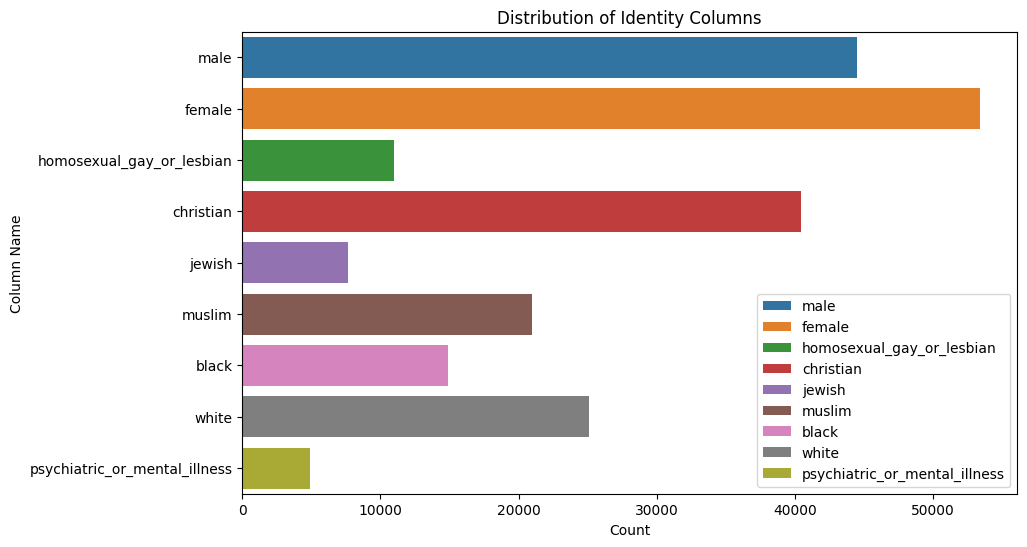

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for column in IDENTITY_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Identity Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

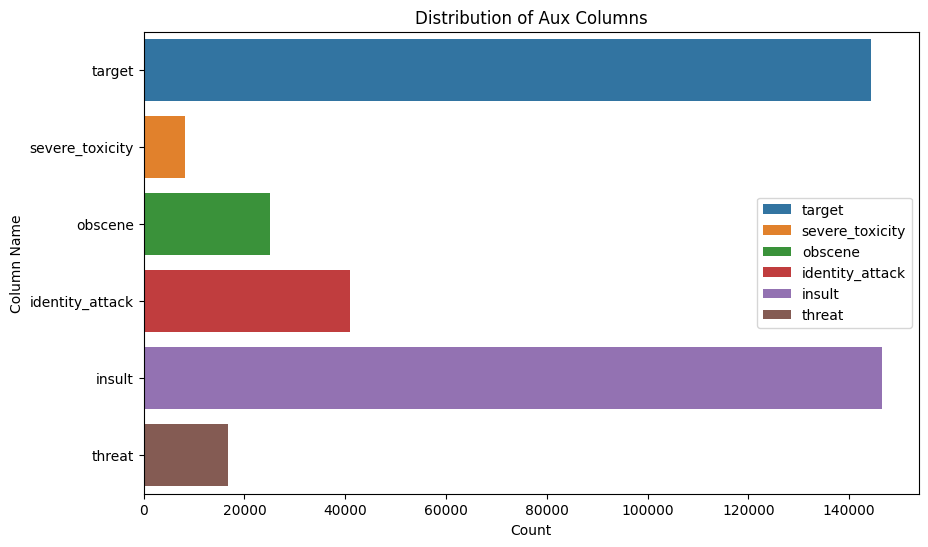

In [16]:
plt.figure(figsize=(10, 6))
for column in AUX_COLUMNS:
    sns.barplot(x=train_df[column].sum(), y=[column], label=column, orient='h')
plt.title('Distribution of Aux Columns')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend()
plt.show()

In [23]:
import shap

In [46]:
import shap, sklearn
from tensorflow.keras.preprocessing.sequence import pad_sequences
word_index = tokenizer.word_index
reverse_word_index = {index: word for word, index in word_index.items()}
feature_names_out = list(word_index.values())
feature_names_in = list(word_index.keys())

In [47]:
explainer = shap.Explainer(model, feature_names_in)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=feature_names_out)

TypeError: 'list' object is not callable

In [7]:
for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)

KeyboardInterrupt: 